In [1]:
import sqlite3
from pathlib import Path

__file__ = %pwd
DATA = Path(__file__).parent.parent / "data"
PRIORITIES = DATA / "Priorities"
DATABASE = DATA / "databases" / "exploration.db"

import sys
sys.path.append(str(DATA.parent))  # Add the parent directory of 'modeling' to the Python path

con = sqlite3.connect(DATABASE)
cur = con.cursor()

In [2]:
import pandas as pd
import numpy as np


def filter_academic_year(df, year):
    """Filter dataframe by academic year and drop AcademicYear column"""
    filtered_df = df[df["Year"] == year].copy()
    return filtered_df.drop(columns=["Year"])


def standarized_columns(acgr_df, mapping):
    """Rename ACGR columns to match Census Day naming convention"""
    renamed_df = acgr_df.copy()
    new_columns = {}

    for col in acgr_df.columns:
        parts = col.split(".")
        if len(parts) == 2 and parts[1] in mapping:
            new_col = f"{parts[0]}.{mapping[parts[1]]}"
            new_columns[col] = new_col

    return renamed_df.rename(columns=new_columns)


census_to_acgr_mapping = {
    # Race/Ethnicity
    "RE_B": "RB",  # African American
    "RE_I": "RI",  # American Indian or Alaska Native
    "RE_A": "RA",  # Asian
    "RE_F": "RF",  # Filipino
    "RE_H": "RH",  # Hispanic or Latino
    "RE_D": "RD",  # Not Reported
    "RE_P": "RP",  # Pacific Islander
    "RE_T": "RT",  # Two or More Races
    "RE_W": "RW",  # White
    # Gender
    "GN_M": "GM",  # Male
    "GN_F": "GF",  # Female
    "GN_X": "GX",  # Non-Binary
    "GN_Z": "GZ",  # Missing Gender
    # Student Groups
    "SG_EL": "SE",  # English Learners
    "SG_DS": "SD",  # Students with Disabilities
    "SG_SD": "SS",  # Socioeconomically Disadvantaged
    "SG_MG": "SM",  # Migrant
    "SG_FS": "SF",  # Foster
    "SG_HM": "SH",  # Homeless
    # Total
    "TA": "TA",  # Total
}

In [3]:
from functools import reduce

# Get tables
census_day = pd.read_sql_query("SELECT * FROM CensusDayWide", con)
acgr = pd.read_sql_query("SELECT * FROM ACGRWide", con)
ela_scores = pd.read_sql_query("SELECT * FROM ELAWide", con)
math_scores = pd.read_sql_query("SELECT * FROM MathWide", con)
public_schools = pd.read_sql_query("SELECT * FROM PublicSchools", con)

grade_cols_to_keep = ["GR_09", "GR_10", "GR_11", "GR_12"]
cols_to_keep = [
    col
    for col in census_day.columns
    if not col.startswith("GR_") or any(col.startswith(g) for g in grade_cols_to_keep)
]
census_day = census_day[cols_to_keep]

pattern = "Virtual|Magnet|YearRound|Multilingual"
public_schools = public_schools.filter(regex=pattern)
census_day_standardized = standarized_columns(census_day, census_to_acgr_mapping)


def add_suffix_except(df, suffix, exclude=("SchoolCode", "AcademicYear")):
    return df.rename(
        columns={col: f"{col}{suffix}" for col in df.columns if col not in exclude}
    )


ela_scores_suffixed = add_suffix_except(ela_scores, "_ELA")
math_scores_suffixed = add_suffix_except(math_scores, "_Math")

# Reduce columns
census_day_reduced = census_day.drop(
    columns=["AggregateLevel", "DistrictCode", "CountyCode"], errors="ignore"
)
acgr_reduced = acgr.drop(columns=["DistrictCode", "CountyCode"], errors="ignore")
ela_scores_reduced = ela_scores_suffixed.drop(
    columns=["AggregateLevel", "DistrictCode", "CountyCode"], errors="ignore"
)
math_scores_reduced = math_scores_suffixed.drop(
    columns=["AggregateLevel", "DistrictCode", "CountyCode"], errors="ignore"
)

# Merge DataFrames
dfs = [
    acgr_reduced,
    ela_scores_reduced,
    math_scores_reduced,
]

merged = reduce(
    lambda left, right: pd.merge(left, right, on="SchoolCode", how="inner"), dfs
)
merged

,AggregateLevel,CharterSchool,SchoolCode,Year,cdsCode,AdultEd.GF,AdultEdRate.GF,Biliteracy.GF,BiliteracyRate.GF,CPP.GF,...,currdenom.SWD_Math,currstatus.SWD_Math,currdenom.WH_Math,currstatus.WH_Math,currdenom.PI_Math,currstatus.PI_Math,currdenom.AI_Math,currstatus.AI_Math,currdenom.HOM_Math,currstatus.HOM_Math
0,S,No,131755,2023-24,1316090131755,NaN,NaN,NaN,NaN,NaN,...,19.0,-168.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,S,No,131755,2023-24,1316090131755,NaN,NaN,NaN,NaN,NaN,...,22.0,-204.7,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,S,No,131755,2023-24,1316090131755,NaN,NaN,NaN,NaN,NaN,...,25.0,-182.1,4.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,S,No,131755,2023-24,1316090131755,NaN,NaN,NaN,NaN,NaN,...,19.0,-131.1,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,S,No,131755,2023-24,1316090131755,NaN,NaN,NaN,NaN,NaN,...,19.0,-168.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350472,S,No,5838305,2016-17,58727695838305,0.0,0.0,3.0,4.0,0.0,...,36.0,-197.0,110.0,-73.9,2.0,NaN,2.0,NaN,11.0,-141.1
350473,S,No,5838305,2016-17,58727695838305,0.0,0.0,3.0,4.0,0.0,...,32.0,-189.6,84.0,-104.0,4.0,NaN,3.0,NaN,4.0,NaN
350474,S,No,5838305,2016-17,58727695838305,0.0,0.0,3.0,4.0,0.0,...,28.0,-221.3,83.0,-79.0,1.0,NaN,3.0,NaN,2.0,NaN
350475,S,No,5838305,2016-17,58727695838305,0.0,0.0,3.0,4.0,0.0,...,17.0,-225.9,73.0,-42.3,1.0,NaN,1.0,NaN,1.0,NaN


In [4]:
for col in merged.columns:
    if any(substr in col for substr in ["Rate", "Percent", "ENR", "GR_"]):
        merged[col] = pd.to_numeric(merged[col], errors="coerce")

academic_years = [
    "2017-18",
    "2018-19",
    "2021-22",
    "2022-23",
    "2023-24",
]

columns_to_drop = [
    col
    for col in merged.columns
    if col.startswith("RegHSDiploma")
    or col.startswith("Dropout")
    or col.startswith("UniReqs")
    or col.startswith("currstatus")
    or col.startswith("currdenom")
    or col.startswith("Other")
]

year_df_mapping = {year: filter_academic_year(merged, year) for year in academic_years}

## XGBoost

### Math

In [5]:
from modeling.utils.xgboost import cross_validate_xgboost, plot_cv_feature_importance, train_xgboost_model
from modeling.utils.xgboost import (
    plot_top_k_features,
    plot_feature_avg_variance,
    plot_feature_time_series,
)

cv_xgb_models = {}

target_column = "currstatus.ALL_Math"

for year, year_df in year_df_mapping.items():

    cv_result = train_xgboost_model(
        df=year_df,
        target_column=target_column,
        columns_to_drop=[target_column] + columns_to_drop,
        print_plot=False,
        n_jobs=-1,
    )

    cv_xgb_models[year] = cv_result

<Figure size 1400x600 with 0 Axes>

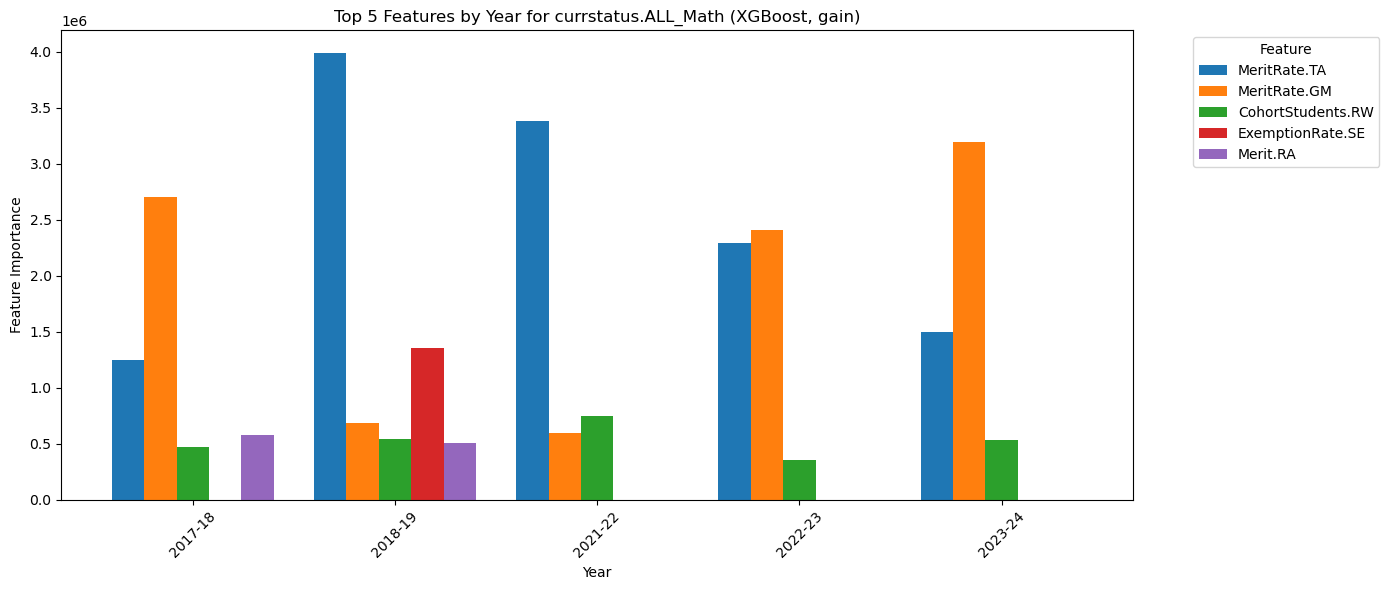

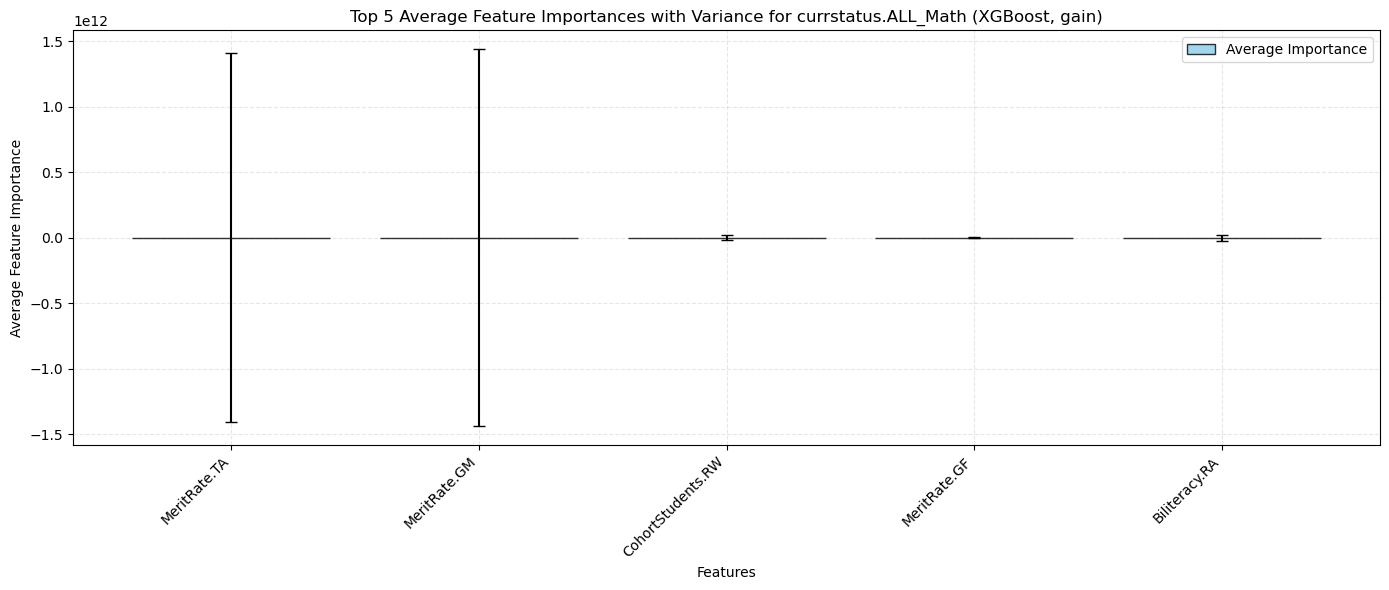

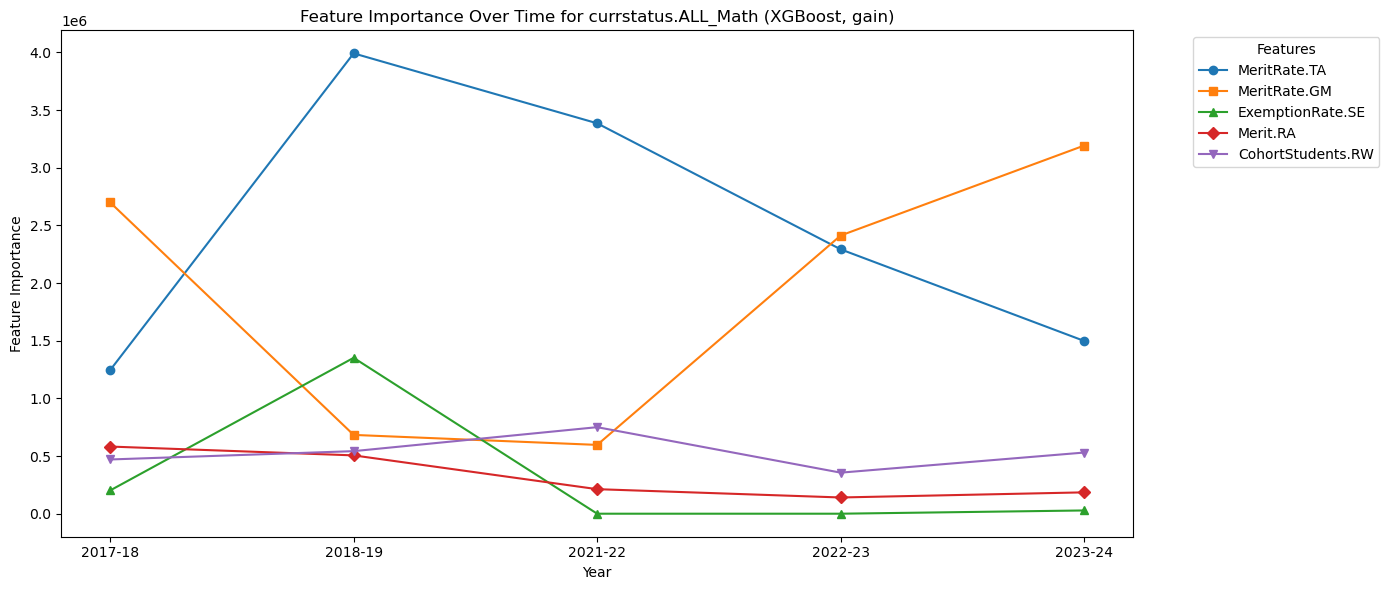

In [6]:
top_features = plot_top_k_features(cv_xgb_models, "XGBoost", "gain", target_column, k=5)
plot_feature_avg_variance(cv_xgb_models, "XGBoost", "gain", target_column)
plot_feature_time_series(
    cv_xgb_models, "XGBoost", "gain", target_column, top_features
)

### ELA

In [7]:
from modeling.utils.xgboost import cross_validate_xgboost, plot_cv_feature_importance, train_xgboost_model
from modeling.utils.xgboost import (
    plot_top_k_features,
    plot_feature_avg_variance,
    plot_feature_time_series,
)

cv_xgb_models = {}

target_column = "currstatus.ALL_ELA"

for year, year_df in year_df_mapping.items():

    cv_result = train_xgboost_model(
        df=year_df,
        target_column=target_column,
        columns_to_drop=[target_column] + columns_to_drop,
        n_jobs=-1,
        print_plot=False,
    )

    cv_xgb_models[year] = cv_result

<Figure size 1400x600 with 0 Axes>

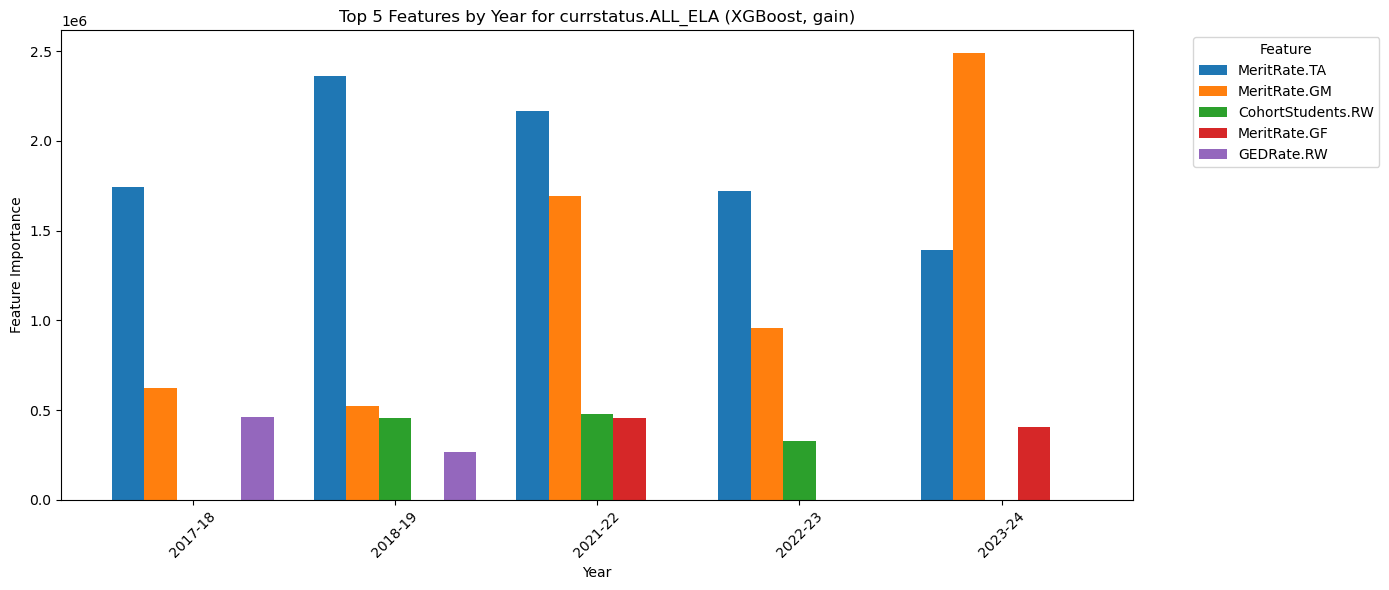

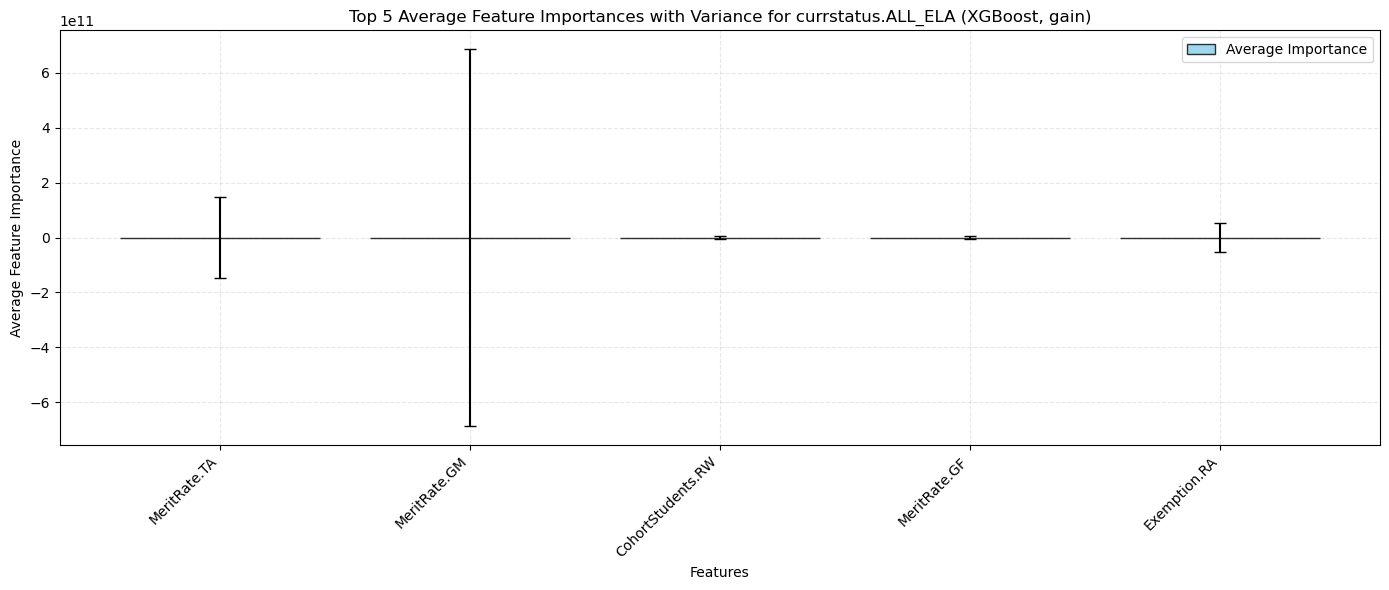

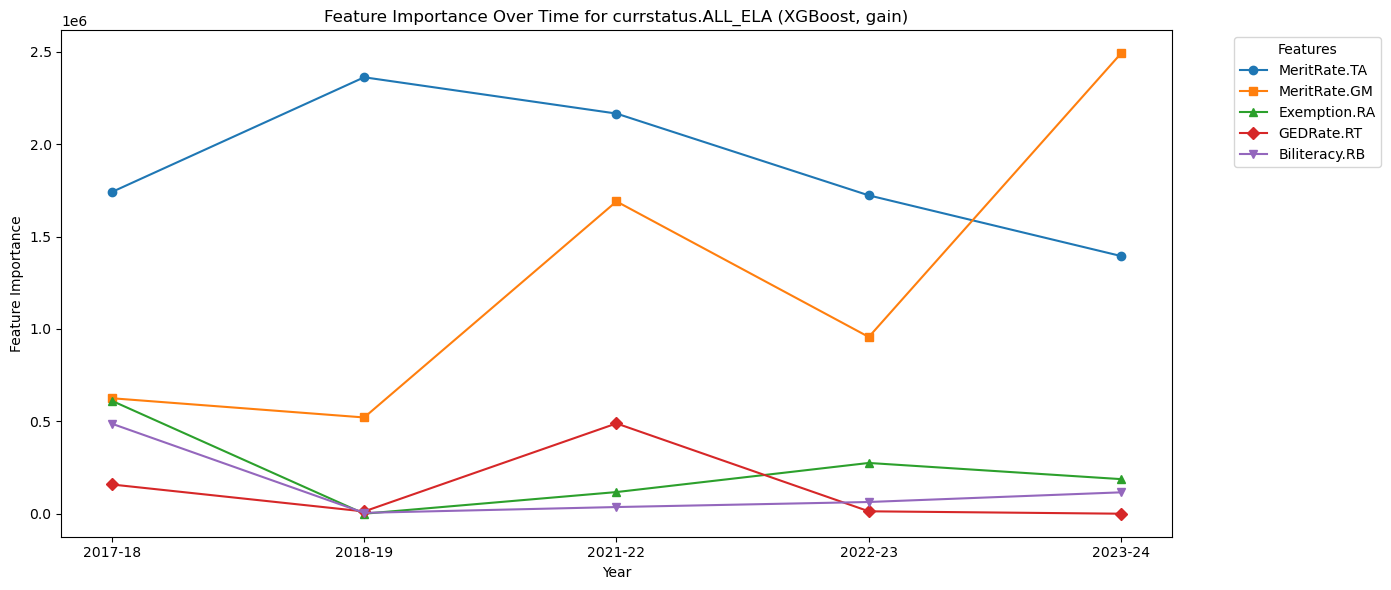

In [8]:
top_features = plot_top_k_features(cv_xgb_models, "XGBoost", "gain", target_column, k=5)
plot_feature_avg_variance(cv_xgb_models, "XGBoost", "gain", target_column)
plot_feature_time_series(
    cv_xgb_models, "XGBoost", "gain", target_column, top_features
)

## Random Forest

### MATH

In [9]:
from modeling.utils.randomforest import (
    plot_cv_feature_importance_rf,
    plot_top_k_features_rf,
    plot_feature_avg_variance_rf,
    plot_feature_time_series_rf,
    train_random_forest_model
)

cv_models = {}

target_variable = "currstatus.ALL_Math"
years = list(year_df_mapping.keys())

for year in years:
    df = year_df_mapping[year]

    cv_result = train_random_forest_model(
        df=df,
        target_column=target_variable,
        columns_to_drop=columns_to_drop,
        print_results=True,
        n_jobs=-1,
    )

    cv_models[year] = cv_result

Random Forest Regression Results for currstatus.ALL_Math:
RMSE: 24.4673
MSE: 598.6494
R²: 0.8627
Random Forest Regression Results for currstatus.ALL_Math:
RMSE: 24.3557
MSE: 593.1989
R²: 0.8699
Random Forest Regression Results for currstatus.ALL_Math:
RMSE: 24.2744
MSE: 589.2453
R²: 0.8706
Random Forest Regression Results for currstatus.ALL_Math:
RMSE: 24.4086
MSE: 595.7794
R²: 0.8708
Random Forest Regression Results for currstatus.ALL_Math:
RMSE: 23.9158
MSE: 571.9675
R²: 0.8745


<Figure size 1400x600 with 0 Axes>

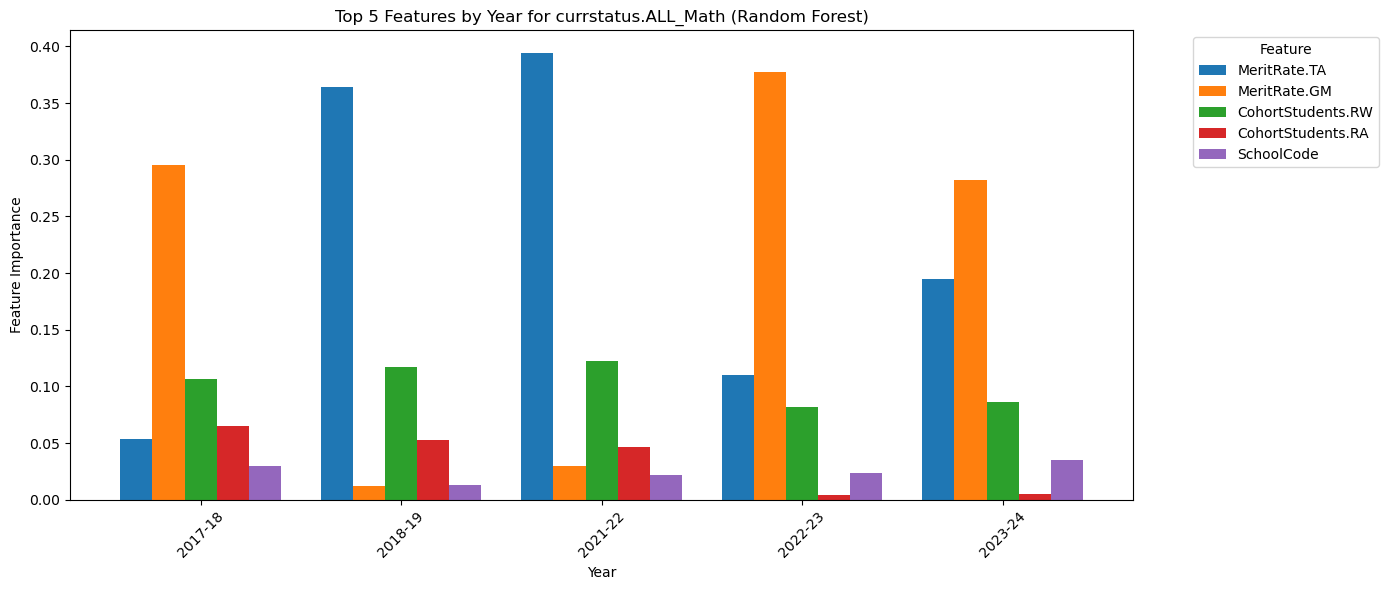

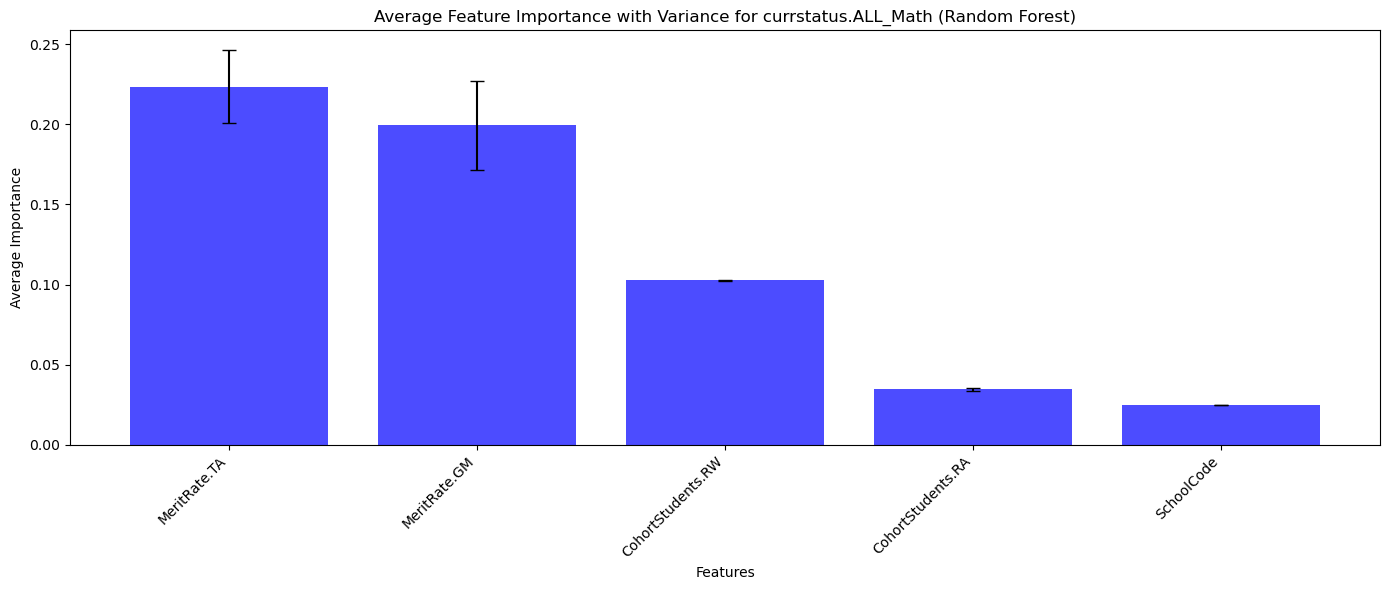

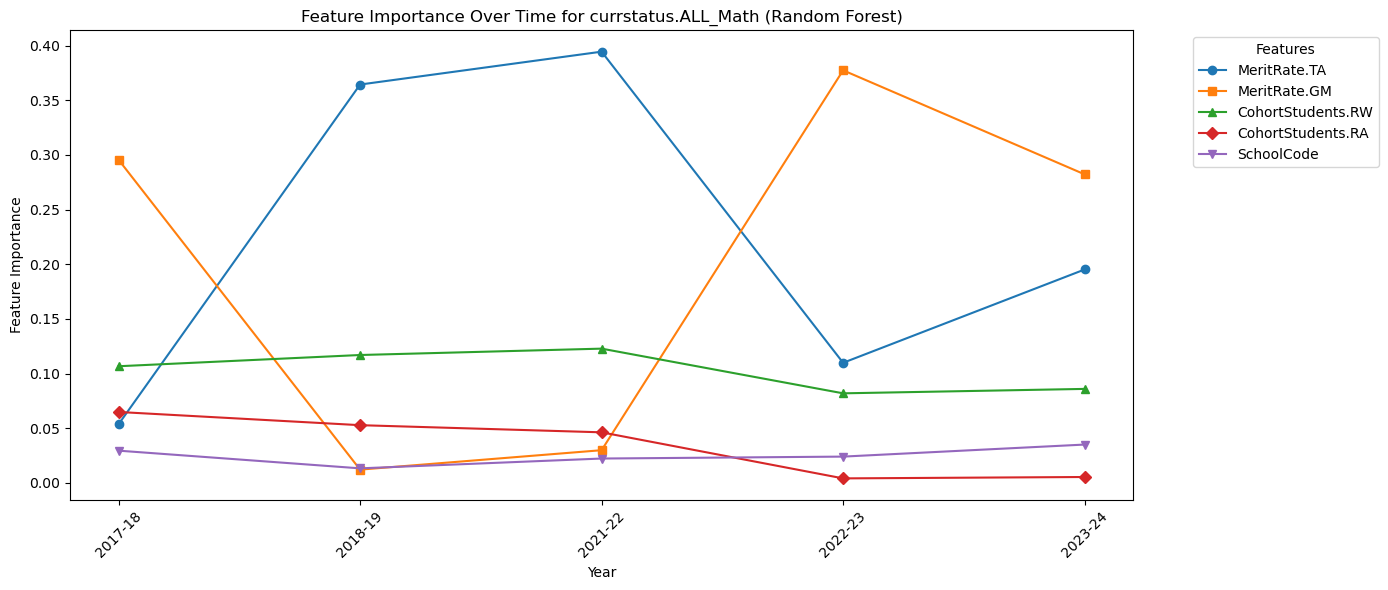

In [10]:
all_top_features = plot_top_k_features_rf(cv_models, target_variable=target_variable, k=5)
plot_feature_avg_variance_rf(
    cv_models, target_variable=target_variable, top_k_features=all_top_features
)
plot_feature_time_series_rf(
    cv_models, target_variable=target_variable, top_k_features=all_top_features
)

### ELA

In [11]:
from modeling.utils.randomforest import (
    plot_cv_feature_importance_rf,
    plot_top_k_features_rf,
    plot_feature_avg_variance_rf,
    plot_feature_time_series_rf,
    train_random_forest_model
)

cv_models = {}

target_variable = "currstatus.ALL_ELA"
years = list(year_df_mapping.keys())

for year in years:
    df = year_df_mapping[year]

    cv_result = train_random_forest_model(
        df=df,
        target_column=target_variable,
        columns_to_drop=columns_to_drop,
        print_results=True,
        n_jobs=-1,
    )

    cv_models[year] = cv_result

Random Forest Regression Results for currstatus.ALL_ELA:
RMSE: 25.8263
MSE: 666.9974
R²: 0.7976
Random Forest Regression Results for currstatus.ALL_ELA:
RMSE: 26.7601
MSE: 716.1010
R²: 0.7951
Random Forest Regression Results for currstatus.ALL_ELA:
RMSE: 26.3181
MSE: 692.6440
R²: 0.8048
Random Forest Regression Results for currstatus.ALL_ELA:
RMSE: 27.1544
MSE: 737.3615
R²: 0.8015
Random Forest Regression Results for currstatus.ALL_ELA:
RMSE: 27.2139
MSE: 740.5947
R²: 0.7983


<Figure size 1400x600 with 0 Axes>

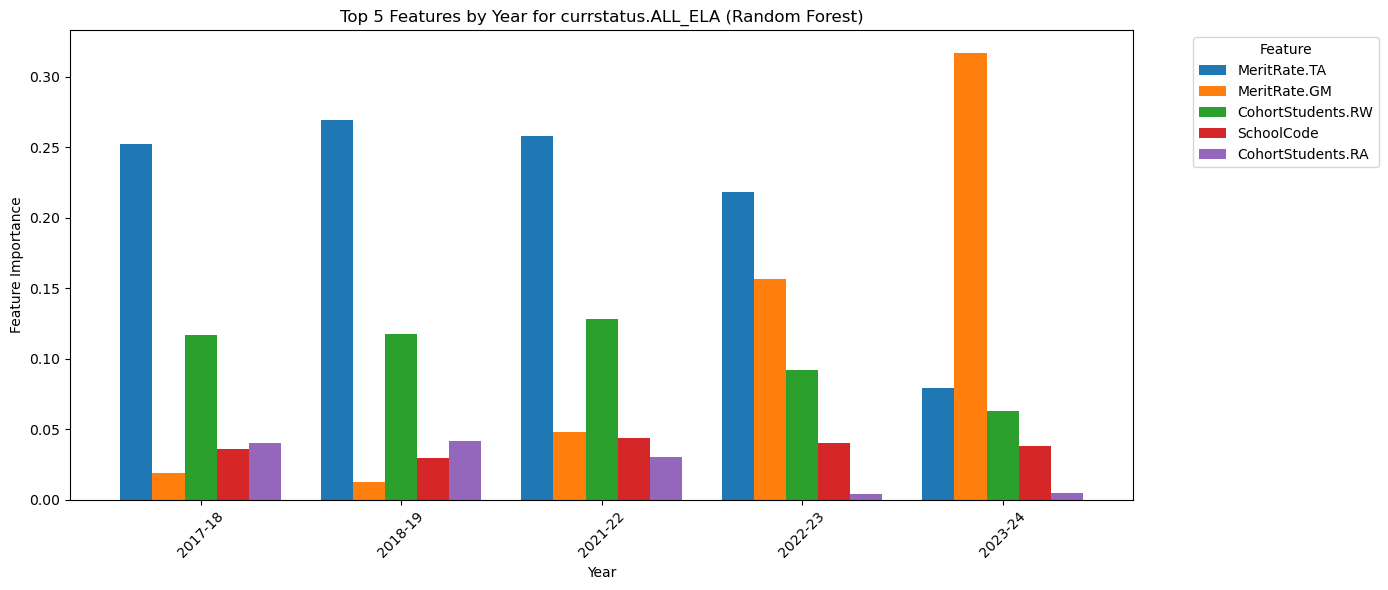

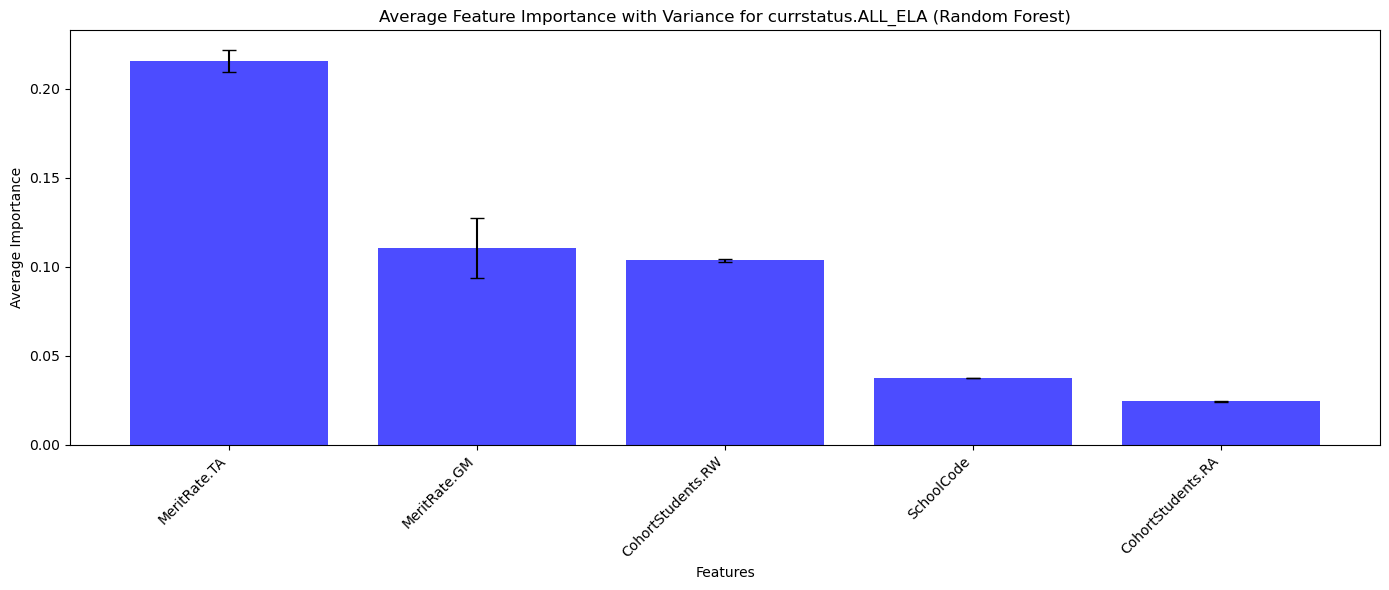

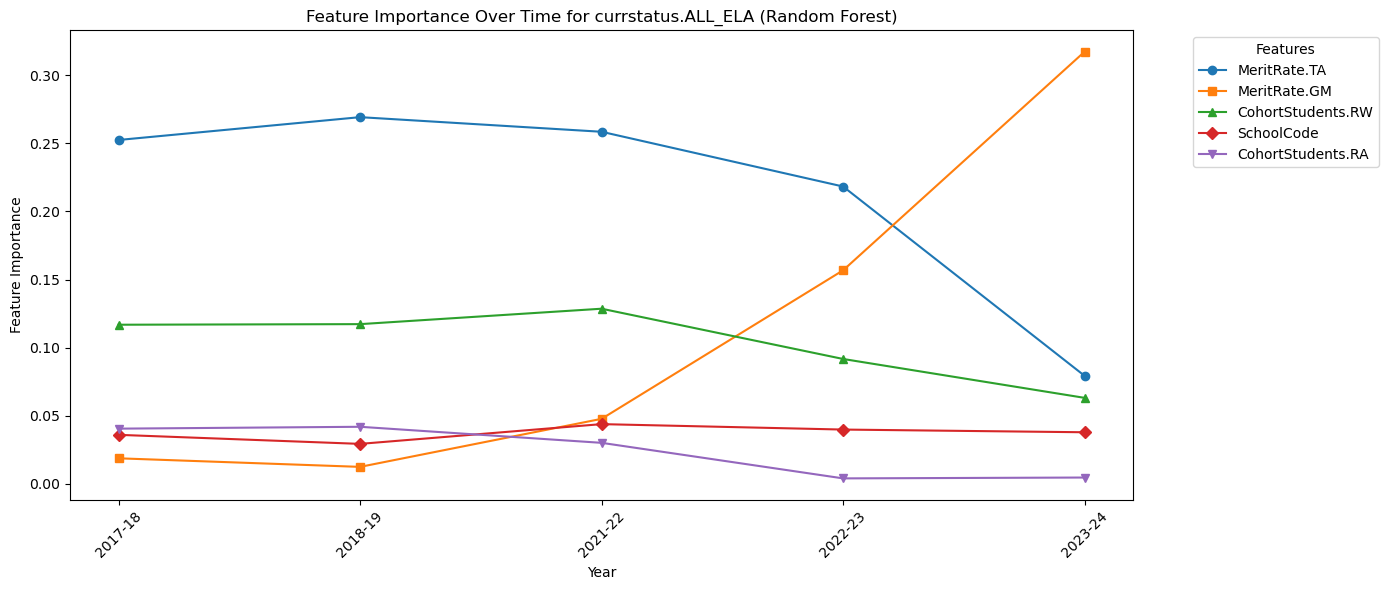

In [13]:
all_top_features = plot_top_k_features_rf(cv_models, target_variable=target_variable, k=5)
plot_feature_avg_variance_rf(
    cv_models, target_variable=target_variable, top_k_features=all_top_features
)
plot_feature_time_series_rf(
    cv_models, target_variable=target_variable, top_k_features=all_top_features
)